In [1]:
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})

import joblib

import catboost
import xgboost as xgb
import lightgbm as lgb

from tqdm import tqdm_notebook
import scipy.optimize as spo
from category_encoders import BinaryEncoder

from sklearn.metrics import mean_squared_error
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import KFold

In [2]:
def run_lgbm(X_train, X_test, y_train, y_test, feature_names, categorical_features='auto', model_params=None, fit_params=None, seed=21):

    X_train_GBM = lgb.Dataset(X_train, label=y_train, feature_name=feature_names, categorical_feature=categorical_features, free_raw_data=False)
    X_test_GBM = lgb.Dataset(X_test, label=y_test, reference=X_train_GBM, feature_name=feature_names, free_raw_data=False)
    
    if model_params is None:
        model_params = {'seed': seed, 'num_threads': 16, 'objective':'root_mean_squared_error', 
                        'metric': ['root_mean_squared_error'] }
        
    if fit_params is None:
        fit_params = {'verbose_eval': True, 'num_boost_round': 300, 'valid_sets': [X_test_GBM], 
                      'early_stopping_rounds': 30,'categorical_feature': categorical_features, 'feature_name': feature_names}
        
    model = lgb.train(model_params, X_train_GBM, **fit_params)
    y_pred = model.predict(X_test, model.best_iteration)
    return model, y_pred, mean_squared_error(y_test, y_pred)

## Lgbm

In [3]:
df_train_dataset = pd.read_pickle('data/df/df_train_dataset_with_ft.pkl')
df_validation_dataset = pd.read_pickle('data/df/df_validation_dataset_with_ft.pkl')

In [4]:
continuous_features = joblib.load('data/iterables/continuous_features_with_ft.joblib')
categorical_features = joblib.load('data/iterables/categorical_features_with_ft.joblib')
target_features = joblib.load('data/iterables/target_features.joblib')
target_transformer = joblib.load('models/preprocessing/target_transformer_with_ft.joblib')

In [5]:
df_train_dataset.shape, df_validation_dataset.shape

((341424, 1810), (146765, 1810))

In [6]:
X = df_train_dataset[categorical_features + continuous_features].values
y = df_train_dataset[target_features].values.flatten()
print(X.shape, y.shape)

(341424, 1803) (341424,)


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.85, test_size=0.15, shuffle=True, random_state=10)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(290210, 1803) (51214, 1803) (290210,) (51214,)


In [9]:
NUM_REGRESSORS = 3

In [10]:
regressors = []

i = 0
seeds = [  6,  66, 219,  91, 236, 201, 242,   4, 145,  37,  80]
seeds = [  6,  63, 219]
rkf = KFold(n_splits=NUM_REGRESSORS, shuffle=True, random_state=21)
for train_index, test_index in tqdm_notebook(rkf.split(X_train, y_train)):
    XTr, XTe = X_train[train_index], X_train[test_index]
    ytr, yte = y_train[train_index], y_train[test_index]
    print(XTr.shape, XTe.shape, ytr.shape, yte.shape)
    
    feature_names = categorical_features + continuous_features
    reg_lgbm, y_pred, score = run_lgbm(XTr, XTe, ytr, yte, feature_names, categorical_features, seed=seeds[i])
    regressors.append(reg_lgbm)
    i += 1

(193473, 1803) (96737, 1803) (193473,) (96737,)


/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['booking_type_code', 'cat_are_all_travelling', 'cat_booking_date_day', 'cat_booking_date_is_weekend', 'cat_booking_date_month', 'cat_booking_date_week', 'cat_booking_date_weekday', 'cat_booking_date_year', 'cat_checkin_date_day', 'cat_checkin_date_is_weekend', 'cat_checkin_date_month', 'cat_checkin_date_week', 'cat_checkin_date_weekday', 'cat_checkin_date_year', 'cat_checkout_date_day', 'cat_checkout_date_is_weekend', 'cat_checkout_date_month', 'cat_checkout_date_week', 'cat_checkout_date_weekday', 'cat_checkout_date_year', 'cat_has_children', 'cat_stay_nights_diff', 'channel_code', 'cluster_code', 'main_product_code', 'member_age_buckets', 'memberid', 'persontravellingid', 'reservationstatusid_code', 'resort_id', 'resort_region_code', 'resort_type_code', 'room_type_booked_code', 'season_holidayed_code', 'state_code_residenc

[1]	valid_0's rmse: 0.13715
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's rmse: 0.135833
[3]	valid_0's rmse: 0.134787
[4]	valid_0's rmse: 0.133907
[5]	valid_0's rmse: 0.133133
[6]	valid_0's rmse: 0.132514
[7]	valid_0's rmse: 0.131977
[8]	valid_0's rmse: 0.131503
[9]	valid_0's rmse: 0.131084
[10]	valid_0's rmse: 0.130773
[11]	valid_0's rmse: 0.130487
[12]	valid_0's rmse: 0.130205
[13]	valid_0's rmse: 0.129991
[14]	valid_0's rmse: 0.129768
[15]	valid_0's rmse: 0.129609
[16]	valid_0's rmse: 0.129424
[17]	valid_0's rmse: 0.129262
[18]	valid_0's rmse: 0.129139
[19]	valid_0's rmse: 0.12901
[20]	valid_0's rmse: 0.128901
[21]	valid_0's rmse: 0.128792
[22]	valid_0's rmse: 0.128688
[23]	valid_0's rmse: 0.128598
[24]	valid_0's rmse: 0.128513
[25]	valid_0's rmse: 0.128434
[26]	valid_0's rmse: 0.128368
[27]	valid_0's rmse: 0.128301
[28]	valid_0's rmse: 0.128256
[29]	valid_0's rmse: 0.1282
[30]	valid_0's rmse: 0.128152
[31]	valid_0's rmse: 0.128098
[32]	valid_0's rmse: 

/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['booking_type_code', 'cat_are_all_travelling', 'cat_booking_date_day', 'cat_booking_date_is_weekend', 'cat_booking_date_month', 'cat_booking_date_week', 'cat_booking_date_weekday', 'cat_booking_date_year', 'cat_checkin_date_day', 'cat_checkin_date_is_weekend', 'cat_checkin_date_month', 'cat_checkin_date_week', 'cat_checkin_date_weekday', 'cat_checkin_date_year', 'cat_checkout_date_day', 'cat_checkout_date_is_weekend', 'cat_checkout_date_month', 'cat_checkout_date_week', 'cat_checkout_date_weekday', 'cat_checkout_date_year', 'cat_has_children', 'cat_stay_nights_diff', 'channel_code', 'cluster_code', 'main_product_code', 'member_age_buckets', 'memberid', 'persontravellingid', 'reservationstatusid_code', 'resort_id', 'resort_region_code', 'resort_type_code', 'room_type_booked_code', 'season_holidayed_code', 'state_code_residenc

[1]	valid_0's rmse: 0.135799
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's rmse: 0.134481
[3]	valid_0's rmse: 0.133446
[4]	valid_0's rmse: 0.132537
[5]	valid_0's rmse: 0.131791
[6]	valid_0's rmse: 0.131185
[7]	valid_0's rmse: 0.130618
[8]	valid_0's rmse: 0.13012
[9]	valid_0's rmse: 0.129726
[10]	valid_0's rmse: 0.129384
[11]	valid_0's rmse: 0.129087
[12]	valid_0's rmse: 0.128831
[13]	valid_0's rmse: 0.128565
[14]	valid_0's rmse: 0.128359
[15]	valid_0's rmse: 0.128151
[16]	valid_0's rmse: 0.12799
[17]	valid_0's rmse: 0.127842
[18]	valid_0's rmse: 0.127705
[19]	valid_0's rmse: 0.127586
[20]	valid_0's rmse: 0.127475
[21]	valid_0's rmse: 0.127362
[22]	valid_0's rmse: 0.127274
[23]	valid_0's rmse: 0.127184
[24]	valid_0's rmse: 0.12711
[25]	valid_0's rmse: 0.127031
[26]	valid_0's rmse: 0.126965
[27]	valid_0's rmse: 0.126913
[28]	valid_0's rmse: 0.126854
[29]	valid_0's rmse: 0.12681
[30]	valid_0's rmse: 0.12678
[31]	valid_0's rmse: 0.12673
[32]	valid_0's rmse: 0.

/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['booking_type_code', 'cat_are_all_travelling', 'cat_booking_date_day', 'cat_booking_date_is_weekend', 'cat_booking_date_month', 'cat_booking_date_week', 'cat_booking_date_weekday', 'cat_booking_date_year', 'cat_checkin_date_day', 'cat_checkin_date_is_weekend', 'cat_checkin_date_month', 'cat_checkin_date_week', 'cat_checkin_date_weekday', 'cat_checkin_date_year', 'cat_checkout_date_day', 'cat_checkout_date_is_weekend', 'cat_checkout_date_month', 'cat_checkout_date_week', 'cat_checkout_date_weekday', 'cat_checkout_date_year', 'cat_has_children', 'cat_stay_nights_diff', 'channel_code', 'cluster_code', 'main_product_code', 'member_age_buckets', 'memberid', 'persontravellingid', 'reservationstatusid_code', 'resort_id', 'resort_region_code', 'resort_type_code', 'room_type_booked_code', 'season_holidayed_code', 'state_code_residenc

[1]	valid_0's rmse: 0.136416
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's rmse: 0.135109
[3]	valid_0's rmse: 0.134064
[4]	valid_0's rmse: 0.133189
[5]	valid_0's rmse: 0.132409
[6]	valid_0's rmse: 0.131789
[7]	valid_0's rmse: 0.131223
[8]	valid_0's rmse: 0.130759
[9]	valid_0's rmse: 0.13035
[10]	valid_0's rmse: 0.129991
[11]	valid_0's rmse: 0.129705
[12]	valid_0's rmse: 0.129394
[13]	valid_0's rmse: 0.129176
[14]	valid_0's rmse: 0.128947
[15]	valid_0's rmse: 0.12877
[16]	valid_0's rmse: 0.128609
[17]	valid_0's rmse: 0.128444
[18]	valid_0's rmse: 0.128301
[19]	valid_0's rmse: 0.128178
[20]	valid_0's rmse: 0.128059
[21]	valid_0's rmse: 0.127951
[22]	valid_0's rmse: 0.127852
[23]	valid_0's rmse: 0.127757
[24]	valid_0's rmse: 0.127662
[25]	valid_0's rmse: 0.127593
[26]	valid_0's rmse: 0.12753
[27]	valid_0's rmse: 0.127455
[28]	valid_0's rmse: 0.1274
[29]	valid_0's rmse: 0.127331
[30]	valid_0's rmse: 0.127282
[31]	valid_0's rmse: 0.127239
[32]	valid_0's rmse: 0

In [11]:
predictions_dataset = {'y_pred_{}'.format(i): None for i in range(regressors.__len__())}
for i, regressor in enumerate(tqdm_notebook(regressors)):
    predictions_dataset['y_pred_{}'.format(i)] = regressor.predict(X_test, regressor.best_iteration)
df_preditions = pd.DataFrame(predictions_dataset)
df_preditions.head()

,y_pred_0,y_pred_1,y_pred_2
0,2.196267,2.177682,2.179373
1,2.101054,2.107042,2.102269
2,2.088819,2.087728,2.066472
3,2.157820,2.159948,2.157468
4,2.125878,2.096152,2.098049


In [12]:
def fo_minimize(z, *args):
    df = args[0]
    y_test = args[1]
    
    s_ = pd.Series(np.zeros(df.shape[0], ))
    for midx, multiplier in enumerate(z):
        s_ += df.iloc[:, midx] * multiplier

    s_ = s_ / np.sum(z)
    return mean_squared_error(y_test, s_.values) ** .5

In [13]:
xopt, fopt , _, _, _ = spo.fmin(fo_minimize, [0.5] * NUM_REGRESSORS, args=(df_preditions, y_test), maxiter=600, disp=False, full_output=True)

In [14]:
xopt, fopt 

(array([0.40062308, 0.62871097, 0.4566787 ]), 0.12445667389255209)

In [15]:
X_val = df_validation_dataset[categorical_features + continuous_features].values
predictions_val_dataset = {'y_pred_val{}'.format(i): None for i in range(regressors.__len__())}
for i, regressor in enumerate(tqdm_notebook(regressors)):
    predictions_val_dataset['y_pred_val{}'.format(i)] = regressor.predict(X_val, regressor.best_iteration)
df_preditions_val = pd.DataFrame(predictions_val_dataset)

In [16]:
s_ = pd.Series(np.zeros(df_preditions_val.shape[0], ))
for midx, multiplier in enumerate(xopt):
    s_ += df_preditions_val.iloc[:, midx] * multiplier
s_ = s_ / np.sum(xopt)

In [17]:
y_pred_val = target_transformer.inverse_transform(np.expand_dims(s_.values, axis=1))

In [18]:
df_validation_dataset[target_features] = y_pred_val
df_validation_dataset[['reservation_id', 'amount_spent_per_room_night_scaled']].to_csv('submission.csv', index=False)

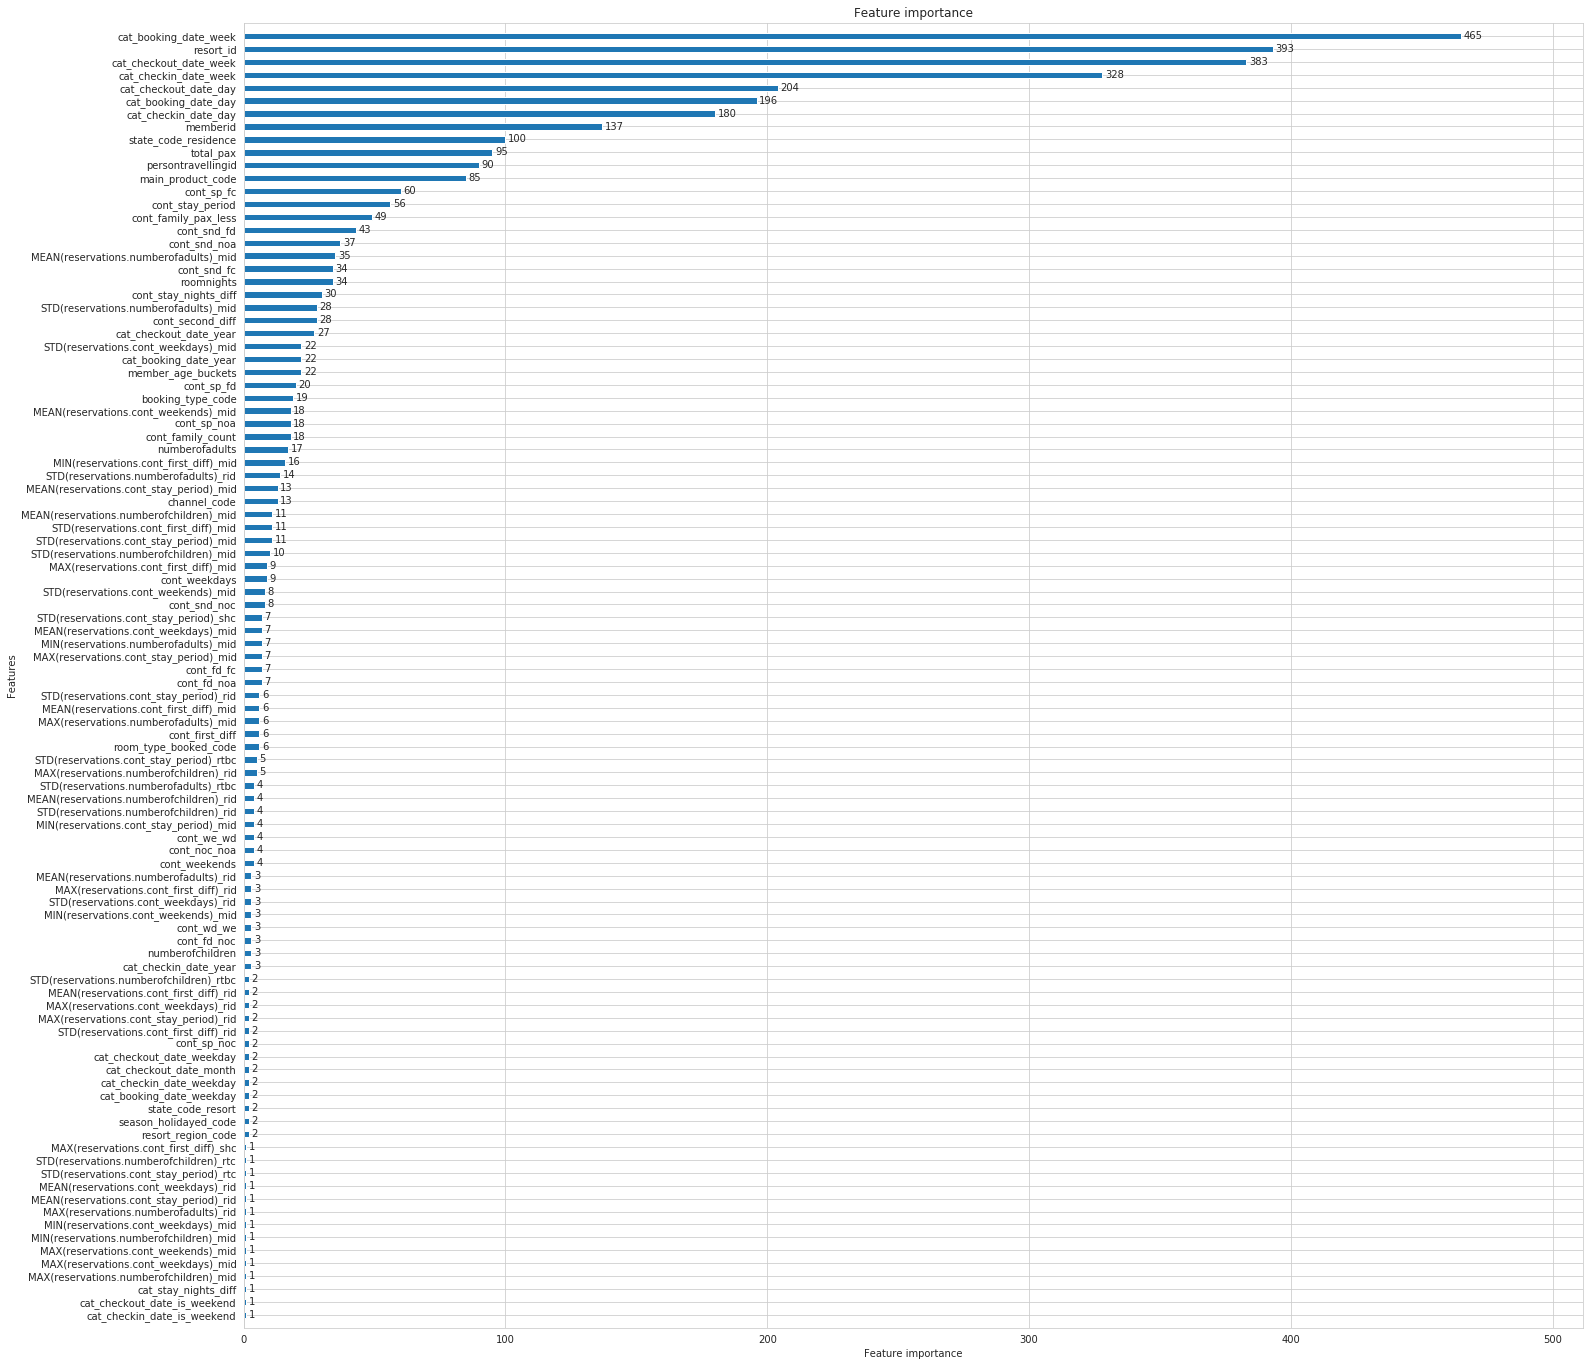

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(24, 24)
lgb.plot_importance(regressors[0], ax=ax, height=0.5, max_num_features=100);

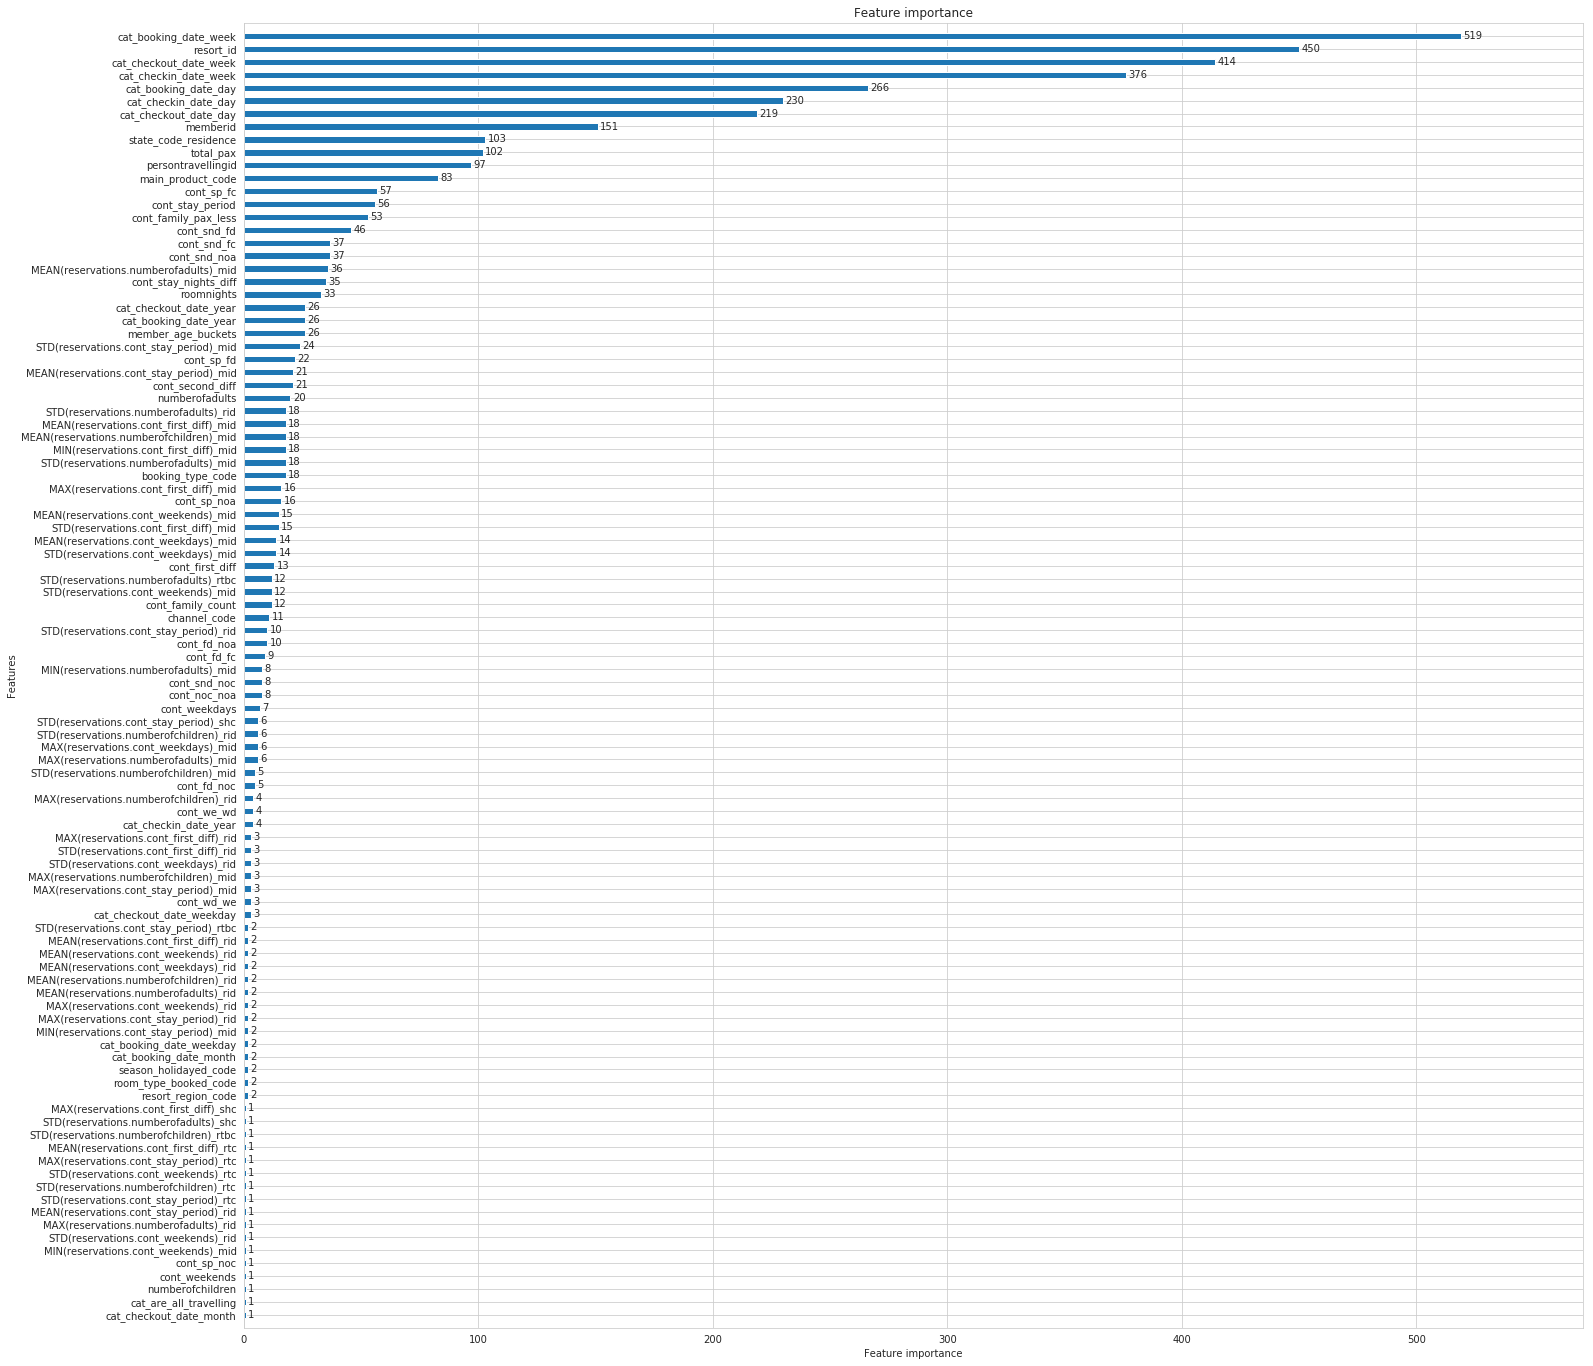

In [19]:
fig, ax = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(24, 24)
lgb.plot_importance(regressors[1], ax=ax, height=0.5, max_num_features=100);

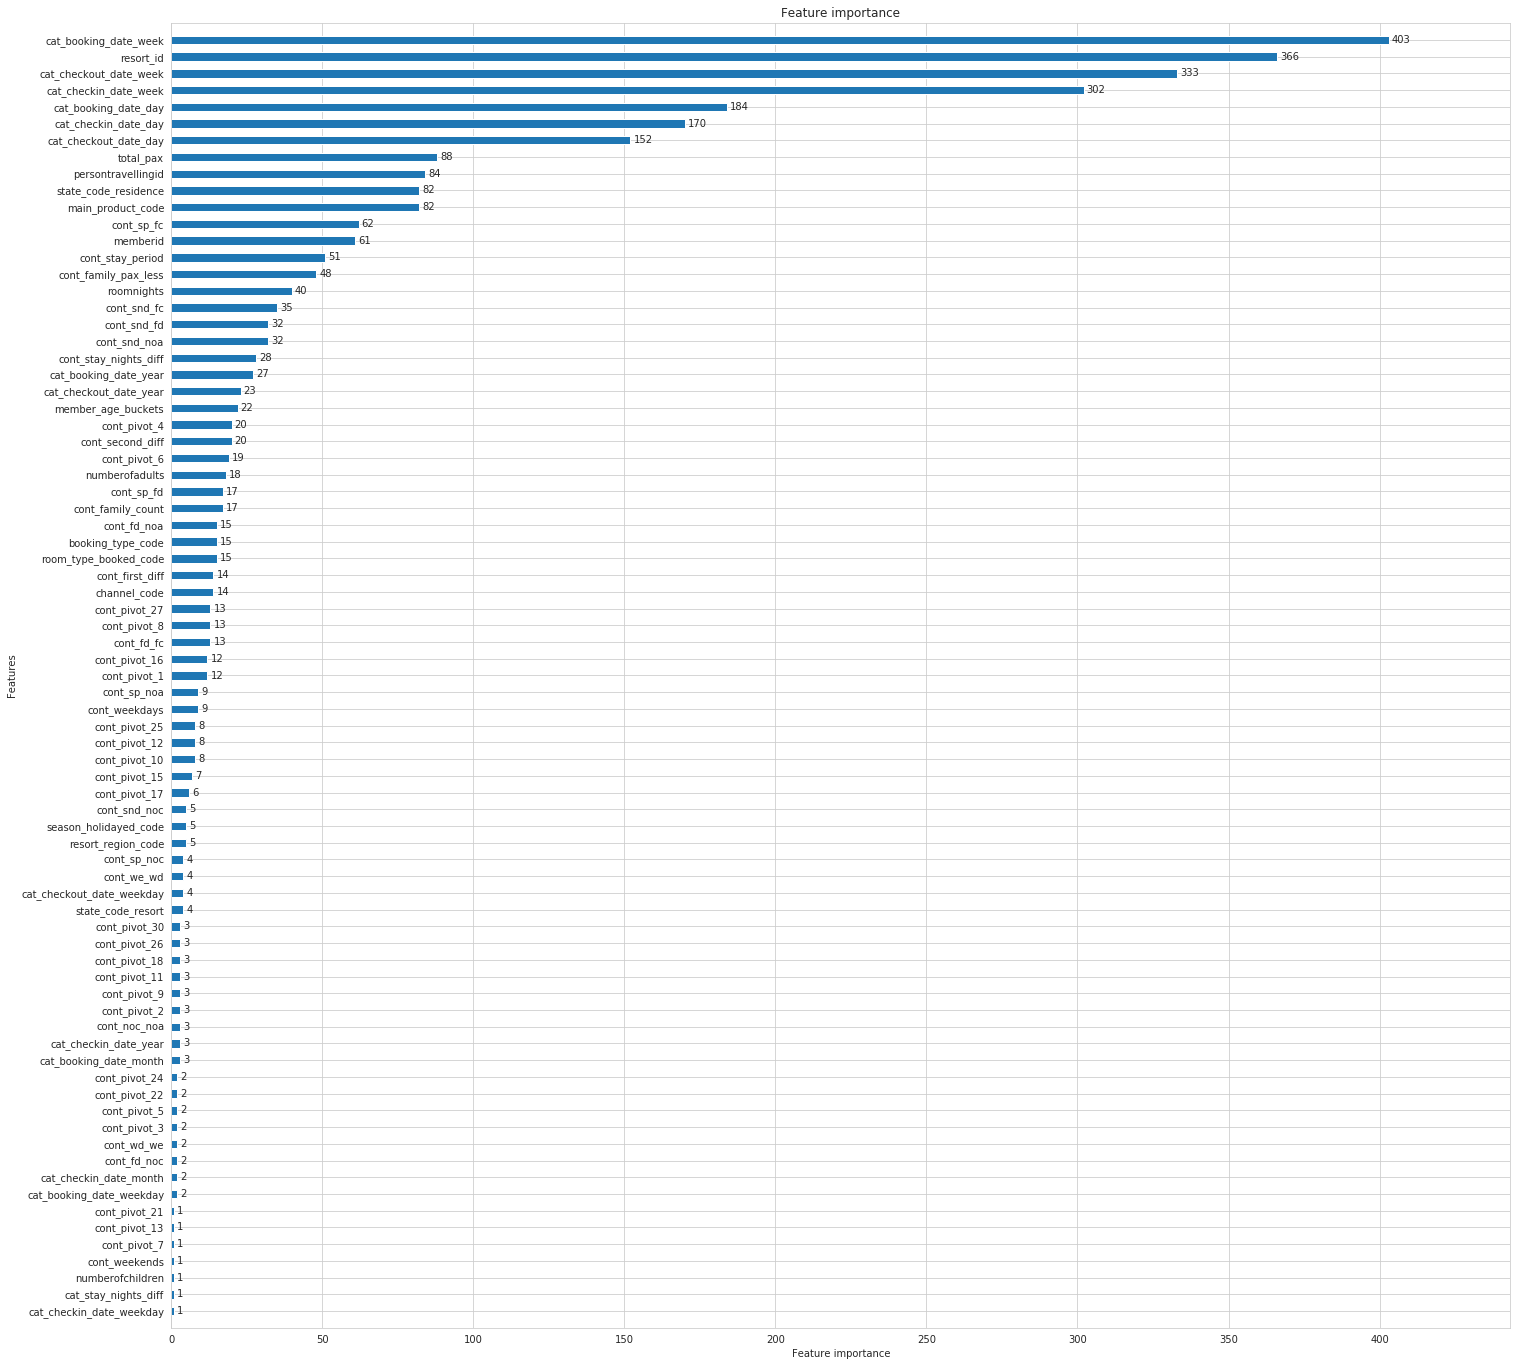

In [69]:
fig, ax = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(24, 24)
lgb.plot_importance(regressors[2], ax=ax, height=0.5, max_num_features=100);